# Fit Growth Assay data to 4 parameter logistic (4PL) equation <br>
### importing libraries

In [3]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

## 4PL equation
The usual formula is:<br>
$$
f(t) = D + \frac{A-D}{1 + \left(\frac{t}{C}\right)^B}
$$
where: <br>
 - $A$ - the minimum value that can be obtained (i.e. what happens at 0 dose) <br> 
 - $B$ - Hill’s slope of the curve (i.e. this is related to the steepness of the curve at point c). <br>
 - $C$ - the point of inflection (i.e. the point on the S shaped curve halfway between a and d) <br>
 - $D$ - the maximum value that can be obtained (i.e. what happens at infinite dose)<br>
<br> 
Note that four parameter logistic (4PL) curves are symmetric in nature around the inflection point. For asymmetric logistic curves, a five parameter logistic (5PL) curve is required.

In [4]:
def _func_4PL(A=0.5, B=2.5, C=8, D=7.3, t=np.linspace(0, 15, 1000)):
    return D+((A-D)/(1+((t/C)**B)))

### The Parameters
Vary each parameter in order to see their respective influence:

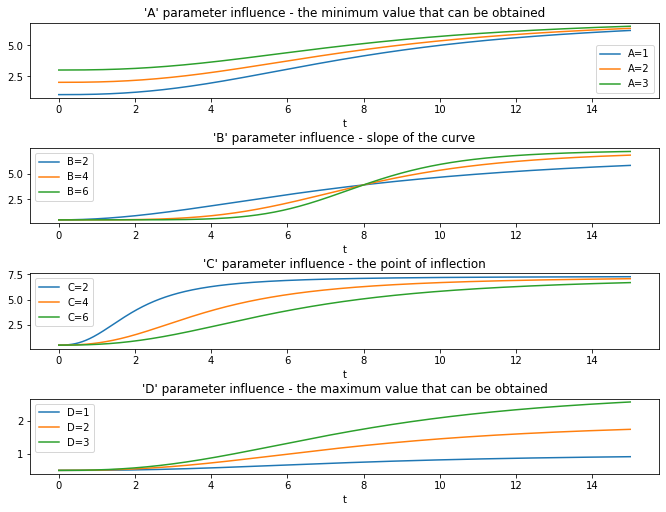

In [5]:
t = np.linspace(0, 15, 1000)
fig = plt.figure(figsize=(9, 7))

# vary A
ax = fig.add_subplot(4, 1, 1)
for A in [1, 2, 3]:
    f = _func_4PL(A=A)
    _ = plt.plot(t, f, label=f'A={A}')
_ = ax.legend()
_ = ax.set_xlabel('t')
_ = plt.title("'A' parameter influence - the minimum value that can be obtained")

# vary B
ax = fig.add_subplot(4, 1, 2)
for B in [2, 4, 6]:
    f = _func_4PL(B=B)
    _ = plt.plot(t, f, label=f'B={B}')
_ = ax.legend()
_ = ax.set_xlabel('t')
_ = plt.title("'B' parameter influence - slope of the curve")

# vary C
ax = fig.add_subplot(4, 1, 3)
for C in [2, 4, 6]:
    f = _func_4PL(C=C)
    _ = plt.plot(t, f, label=f'C={C}')
_ = ax.legend()
_ = ax.set_xlabel('t')
_ = plt.title("'C' parameter influence - the point of inflection")

# vary D
ax = fig.add_subplot(4, 1, 4)
for D in [1, 2, 3]:
    f = _func_4PL(D=D)
    _ = plt.plot(t, f, label=f'D={D}')
_ = ax.legend()
_ = ax.set_xlabel('t')
_ = plt.title("'D' parameter influence - the maximum value that can be obtained")

fig.tight_layout(pad=0.3)
plt.show();

## Data
Import data and wrangle it. the result is a dictionary of dataframes, where each key coresspondes to a folder in 'input_directory' <br> 
(plate in the growth assay) and the values are dataframes. <br> 
each dataframe is growth data for one plate in the growth assay. The columns are wells (in 96 well plate), and the rows are timestamps. 

In [6]:
# turn data asc files (raw plate reader files) into dictionary of dataframes

# INPUT: input_directory - string, folder directory, containing subfolders,
#                          each subfolder contains raw asc files for a plate in the growth assay
#                          subfolder names shuld have a number such as 'plate #' or 'Plate #' for the dictionary keys.

# OUTPUT: df_dict - dictionary of dataframes. the keys are the number in the subfolder names in input_directory, 
#                   the values are dataframes where rows=timestemps, columns=wells.
#                   each dataframe in the dictionary correspondes to a plate in the growth assay (subfolder in input_directory).

def wrangle (input_directory):
    df_dict = {}  # init output dictionary with wells as column
    
    for folder in os.listdir(input_directory):  # for each folder (each plate)
        folder_directory = os.path.join(input_directory, folder)
        
        # get sorted list of asc files in 'folder':
        asc_files = [f for f in os.listdir(folder_directory) if f.endswith('.asc')]
        asc_files.remove('Data.asc')
        asc_files = ['Data.asc'] + sorted(asc_files, key=lambda s: int(re.split(r'(\d+)', s)[1]))
        
        # import data from asc files into df (dataframe for current folder)
        wells = pd.read_csv(os.path.join(folder_directory, asc_files[0]), delimiter='\t')['Well positions'][:-2] 
        df = pd.DataFrame(columns=wells)  # init df with column names (wells)
        for cur_file in asc_files:  # for each asc file in 'folder'
            cur_data = ((pd.read_csv(os.path.join(folder_directory, cur_file), delimiter='\t', usecols=['Raw data']))
                        .dropna()
                        .replace(',', '.', regex=True)
                        .transpose()
                        .rename(columns=wells))
            # add cur_data to df
            df = pd.concat([df, cur_data])
        
        # add df to df_dict
        df_dict[int(re.split(r'(\d+)', folder)[1])] = df.reset_index(drop=True).applymap(float)
        
    return df_dict

In [7]:
folder_dir = 'raw data'
df_dict = wrangle(folder_dir)
df_dict[1].head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0.043826,0.044194,0.044890,0.050453,0.043645,0.044557,0.044248,0.044003,0.043497,0.043322,...,0.048617,0.050681,0.048375,0.050107,0.051267,0.051599,0.053226,0.049843,0.049285,0.055510
1,0.044132,0.044299,0.045313,0.050746,0.043610,0.044141,0.043931,0.043203,0.043211,0.043400,...,0.049530,0.049849,0.050547,0.053755,0.051454,0.050661,0.049731,0.050085,0.050494,0.050228
2,0.043826,0.044707,0.045150,0.051101,0.043612,0.044587,0.044492,0.044196,0.044232,0.043919,...,0.049699,0.049254,0.051444,0.055555,0.055139,0.057100,0.049928,0.048851,0.050407,0.052620
3,0.044374,0.044542,0.044496,0.051319,0.043565,0.044393,0.043955,0.043248,0.043339,0.043480,...,0.049868,0.049225,0.052494,0.055068,0.055293,0.054704,0.048614,0.053047,0.054916,0.054108
4,0.043921,0.044574,0.044960,0.051517,0.044089,0.044487,0.044410,0.043484,0.043419,0.044283,...,0.049939,0.049701,0.052150,0.051078,0.055370,0.051425,0.048981,0.047825,0.049965,0.052180


In [8]:
# export wrangled data
export_directory = '.\output folder'
for k in df_dict:
    (df_dict[k]).to_csv(os.path.join(export_directory, 'wrangled ' + str(k) + '.txt'), index=None, sep='\t')

create timestemps for the measurments: <br>
this is th X axis for plotting and for fitting the data <br>
In this experiment, measurments were taken every 30 minutes, for total of 110 measurments (54.5 hours)

In [9]:
# create evenly spaced numbers over a specified interval
t = np.linspace(0, 54.5, 110)  # [hours]

Visualize raw data:

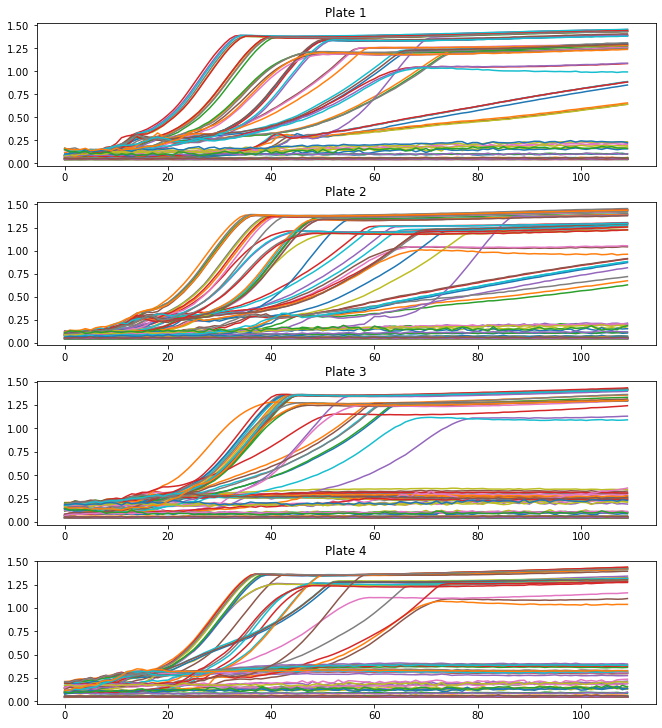

In [10]:
fig = plt.figure(figsize=(9, 10))

for i in range(len(df_dict)):
    ax = fig.add_subplot(4, 1, i+1)
    key = list(df_dict.keys())[i]
    df = df_dict[key]
    df.plot(y=df.columns, ax=ax, title='Plate ' + str(key), legend=False)

fig.tight_layout(pad=0.3)
plt.show();

Average repetitions: <br>
Averageing wells that have the same condition (same media and strain)

In [11]:
# this function average repetitions (wells with the same condition) in the dataframes in df_dict

# INPUT:
#       - GA_conditions_file - file name (string) of xlsx file. 
#                              This file needs to have at least 3 columns: 'Plate', 'Well ID', 'Condition'
#                              Plate = plate number
#                              Well ID = The ID of the wells (row-col: 'A1', 'A2'...)
#                              Condition - The condition in the well (strain / media ...)
#       - df_dict - dictionary where the keys are the plate number (int) and the vlues are the wrangle dataframe
#                   For each dataframe, the columns are wells and the row are timestemps
#       - remove_words_list - list of words (strings) to look for in the 'Condition' column in GA_conditions_file

# OUTPUT:
#       - A dataframe, where every column is a condition, 
#         the values are the mean values of all wells with this condition


def avg_wells_by_condition(GA_conditions_file, df_dict, remove_words_list):
    # load GA_conditions_file into a dataframe (['Plate', 'Well ID', 'Condition'] columns)
    conditions_df = pd.read_excel(GA_conditions_file, usecols=['Plate', 'Well ID', 'Condition'])
    # get conditions list (uniue values), without conditions that have a word from remove_words_list in them
    words = re.compile("|".join(remove_words_list))
    condition_list = [c for c in conditions_df['Condition'].unique() if not words.search(c)]

    # create a dict of edited dataframes from df_dict
    edited_df_dict = {}
    for d in df_dict:
        df = (df_dict[d].transpose()
              .reset_index()
              .rename(columns={'index': 'Well ID'}))
        # use merge to add 'Plate' and 'Condition' columns
        df = df.merge(conditions_df.loc[conditions_df['Plate'] == d, ['Well ID','Condition']], on='Well ID')
        # leave only columns that are in condition_list
        df = df[df['Condition'].isin(condition_list)]
        # add to dict
        edited_df_dict[d] = df
    
    # concat dataframes from edited_df_dict and calculate mean for each Condition
    avg_df = pd.concat(edited_df_dict.values()).groupby(by='Condition').mean().transpose()
    
    return avg_df

In [12]:
GA_conditions_file = 'GA conditions.xlsx'
words = ['Missing', 'blank']

avg_df = avg_wells_by_condition(GA_conditions_file, df_dict, words)
avg_df.head()

Condition,DTT (1mM);BY4741::NAT,DTT (1mM);OE-Yet3,DTT (1mM);dyet3,DTT (2mM);BY4741::NAT,DTT (2mM);OE-Yet3,DTT (2mM);dyet3,Fluconazole (10ug/ml);BY4741::NAT,Fluconazole (10ug/ml);OE-Yet3,Fluconazole (10ug/ml);dyet3,Fluconazole (20ug/ml);BY4741::NAT,...,Terbnarine (10ug/ml);dyet3,Terbnarine (5ug/ml);BY4741::NAT,Terbnarine (5ug/ml);OE-Yet3,Terbnarine (5ug/ml);dyet3,Tunicamycin (2.5 ug/ml);BY4741::NAT,Tunicamycin (2.5 ug/ml);OE-Yet3,Tunicamycin (2.5 ug/ml);dyet3,Tunicamycin (5 ug/ml);BY4741::NAT,Tunicamycin (5 ug/ml);OE-Yet3,Tunicamycin (5 ug/ml);dyet3
0,0.085257,0.085524,0.084867,0.078792,0.082762,0.087691,0.079360,0.080337,0.083121,0.077215,...,0.146663,0.179888,0.169350,0.202688,0.131335,0.134665,0.130698,0.120321,0.121951,0.120996
1,0.090195,0.085925,0.090123,0.092938,0.096492,0.095860,0.087943,0.089194,0.091393,0.090275,...,0.175248,0.185808,0.179803,0.203265,0.129872,0.123458,0.121477,0.127560,0.120803,0.123175
2,0.095833,0.096737,0.098666,0.099296,0.109148,0.111061,0.095361,0.097813,0.103020,0.099052,...,0.173778,0.194943,0.189692,0.219890,0.128751,0.122390,0.121478,0.124719,0.119214,0.124958
3,0.105141,0.102002,0.103679,0.107092,0.112053,0.111382,0.107367,0.108094,0.112489,0.106734,...,0.174943,0.200558,0.193308,0.216187,0.115528,0.114303,0.115366,0.119806,0.118451,0.122303
4,0.109640,0.109846,0.107145,0.115612,0.121755,0.120923,0.109560,0.121222,0.119232,0.110622,...,0.179608,0.208193,0.200760,0.219508,0.122860,0.123337,0.119083,0.114060,0.115482,0.114179


Export final dataframe:

In [13]:
# export wrangled data
export_directory = '.\output folder'
avg_df.to_csv(os.path.join(export_directory, 'full_data.txt'), index=None, sep='\t')

Visualize averaged data:

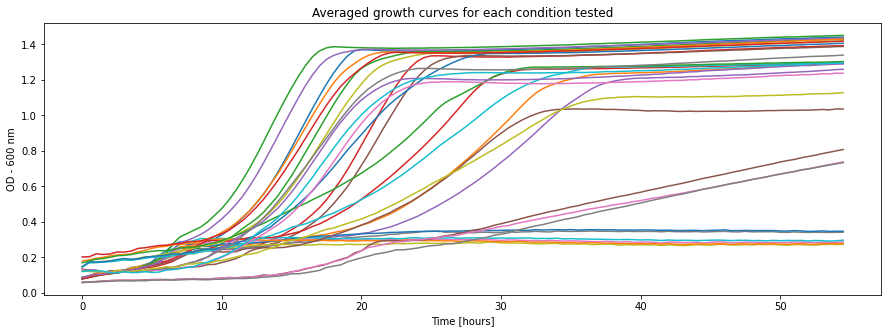

In [14]:
avg_df.set_index(t).plot(legend=False, 
                         figsize=(15,5), 
                         xlabel='Time [hours]', 
                         ylabel='OD - 600 nm', 
                         title='Averaged growth curves for each condition tested');

## Fit data to 4PL equation

Fit data to 4PL equation (use non-linear least squares ):

In [15]:
# helper function - 4 parameter logaritmic equation
def _log4p(t, *p):  
    A, B, C, D = p
    return D+((A-D)/(1+((t/C)**B)))

# fit data to log curve:

# INPUT:
#      - x - x values for the data (timestemps of the growth assay measurments)
#      - df - data frame, contining y values for each x value
#             In a growth assay, the y values are OD measured at time x_i,
#             each column is a different growth condition

# OUTPUT:
#      - fitted_data - data frame, contining predicted values for each x value in each condition
#      - coeff_data - coefficients ['A', 'B', 'C', 'D'] values for each curve fitting

def fit_data_to_log_curve(x, df):
    # init output dataframes
    fitted_data = pd.DataFrame(columns=df.columns)
    coeff_data = pd.DataFrame(columns=df.columns, index=['A', 'B', 'C', 'D'])

    for c in df.columns:  # for each column (condition) in df
        y = df[c]
        p0 = [y.min(), 1, 1, y.max()]
        # fit column c daya (y values) to function _func:
        coeff, _ = curve_fit(_log4p, x, y, p0)
        yfit = [_log4p(xx, *tuple(coeff)) for xx in x]
        # add fitted data to output dataframes
        fitted_data[c] = yfit
        coeff_data[c] = coeff
            
    return fitted_data, coeff_data

In [16]:
fit_df, fit_coeff = fit_data_to_log_curve(t, avg_df)
fit_coeff.head()

<ipython-input-15-a29264d2830a>:4: RuntimeWarning: divide by zero encountered in power
  return D+((A-D)/(1+((t/C)**B)))


Condition,DTT (1mM);BY4741::NAT,DTT (1mM);OE-Yet3,DTT (1mM);dyet3,DTT (2mM);BY4741::NAT,DTT (2mM);OE-Yet3,DTT (2mM);dyet3,Fluconazole (10ug/ml);BY4741::NAT,Fluconazole (10ug/ml);OE-Yet3,Fluconazole (10ug/ml);dyet3,Fluconazole (20ug/ml);BY4741::NAT,...,Terbnarine (10ug/ml);dyet3,Terbnarine (5ug/ml);BY4741::NAT,Terbnarine (5ug/ml);OE-Yet3,Terbnarine (5ug/ml);dyet3,Tunicamycin (2.5 ug/ml);BY4741::NAT,Tunicamycin (2.5 ug/ml);OE-Yet3,Tunicamycin (2.5 ug/ml);dyet3,Tunicamycin (5 ug/ml);BY4741::NAT,Tunicamycin (5 ug/ml);OE-Yet3,Tunicamycin (5 ug/ml);dyet3
A,0.180941,0.224308,0.170071,0.189716,0.216897,0.188706,0.102998,0.091192,0.101511,0.106004,...,0.208754,0.241991,0.243959,0.254329,0.147540,0.168606,0.145230,0.140436,0.158156,0.134005
B,6.929267,6.976631,6.718879,9.046469,6.983467,9.039027,4.998209,1.762703,3.172600,6.714819,...,6.038185,7.211232,4.981532,7.134454,6.372762,6.459277,7.073408,6.183142,4.579332,6.310441
C,14.435042,27.018356,15.586775,19.230803,29.506588,20.098451,5.532236,8.100748,5.587557,5.574280,...,18.742676,14.867508,20.940175,15.347395,15.772302,24.437711,17.025431,15.738717,25.452803,16.654041
D,1.408866,1.305531,1.402836,1.368090,1.287564,1.368321,0.292822,0.360630,0.275552,0.303482,...,1.393961,1.392867,1.328362,1.387985,1.248560,1.060091,1.211948,1.303274,1.186544,1.272592


Visualize fitted data:

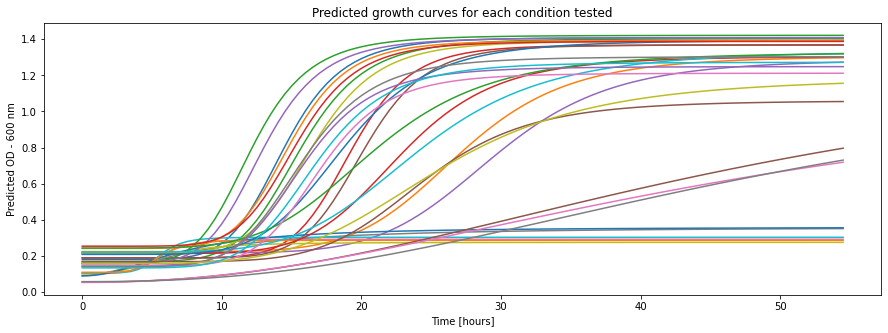

In [17]:
fit_df.set_index(t).plot(legend=False, 
                         figsize=(15,5), 
                         xlabel='Time [hours]', 
                         ylabel='Predicted OD - 600 nm', 
                         title='Predicted growth curves for each condition tested');

plot fitted dava vs. original data:

In [18]:
# this function plot measured data vs fitted data:

# INPUT:
#      - x - x values for the data (timestemps of the growth assay measurments)
#      - df - data frame, contining OD measurments for timestemp x 
#             each column is a different growth condition
#      - df_fit - data frame, contining predicted/ fitted OD for timestemp x 
#                 each column is a different growth condition
#      - cols - optional, list of column names to plot
#               default: cols=[] => plot all columns
# NOTE: both dataframes shuld have same columns and number of rows
#       Both dataframes should have all columns from 'cols'

# OUTPUT: None

def plot_y_vs_y_fit(x, df, df_fit, cols=[]):
    assert all(df.columns == df_fit.columns), 'Both dataframes should have same columns'
    assert len(df) == len(df_fit), 'Both dataframes should have same number of rows'
    assert all([set(cols).issubset(df.columns), 
               set(cols).issubset(df_fit.columns)]), "Both dataframes should have all columns from 'cols'"
    
    if cols:
        df = df[cols]
        df_fit = df_fit[cols]
        n_cols = len(cols)
    else:
        n_cols = len(df.columns)
    
    fig = plt.figure(figsize=(12, 5))
    for i in range(0, n_cols):
        c = df.columns[i]
        ax = fig.add_subplot(n_cols, 1, i+1)
        
        # plot corresponding columns (column c from both dfs)
        _ = plt.plot(t, df[c], label='measured', linestyle='--')
        _ = plt.plot(t, df_fit[c], label='fitted')
        
        _ = ax.legend()
        _ = ax.set_xlabel('Time [hours]')
        _ = plt.title(f"'{c}' growth curves")
        fig.tight_layout(pad=1)
        
    return None

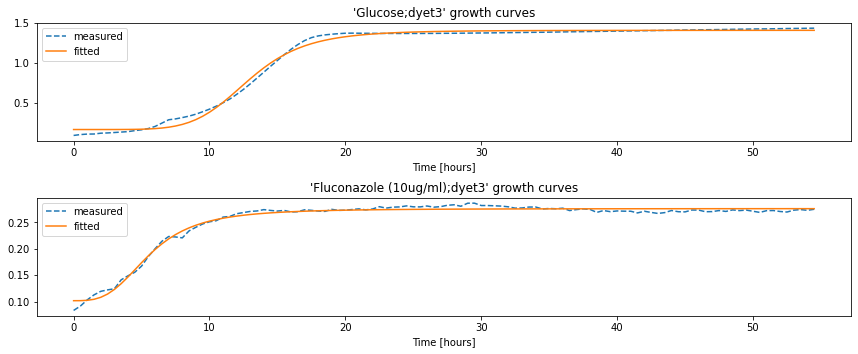

In [19]:
plot_y_vs_y_fit(x=t, df=avg_df, df_fit=fit_df, cols=['Glucose;dyet3', 'Fluconazole (10ug/ml);dyet3'])

Plot coefficients: <br>
* sort by B - slope

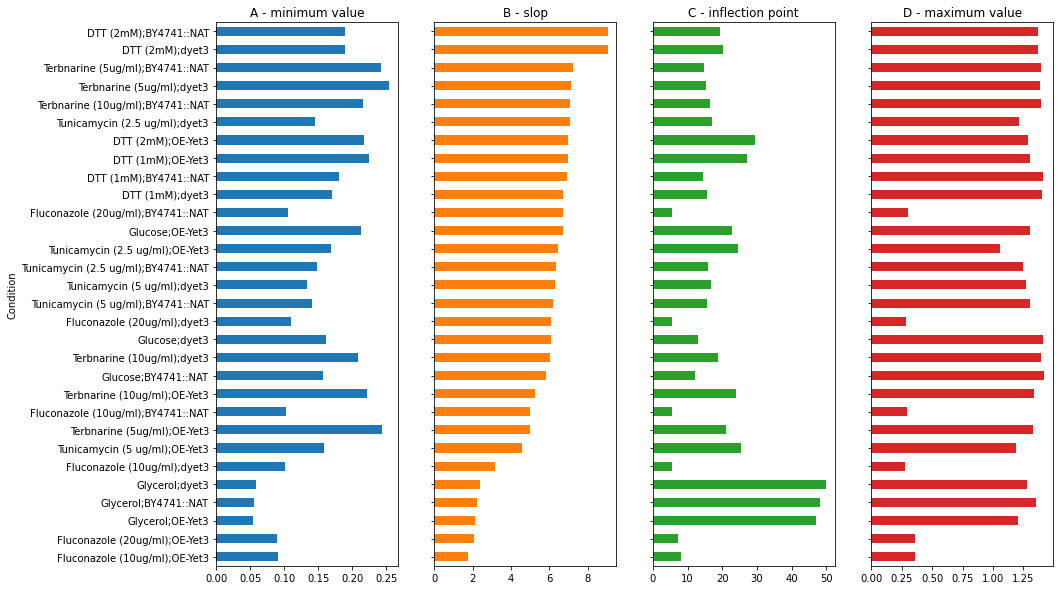

In [20]:
(fit_coeff.transpose().sort_values(by='B')
 .plot(kind='barh', 
       subplots=True, layout=(1, 4), 
       sharey=True, sharex=False,
       legend=False, 
       title=['A - minimum value', 'B - slop', 'C - inflection point', 'D - maximum value'],
       fontsize=10,
       figsize=(15, 10)));

## Goodness-of-Fit 
### R Squared (the coefficient of determination) 
A data set has n values marked $y_1,...,y_n$, each associated with a fitted (or modeled, or predicted) value $\hat{y}_1,...,\hat{y}_n$. <br>
Define the residuals as $e_i = y_i−\hat{y}_i$ (forming a vector e).<br>
The mean of the observed data:<br>
$$ y_{avg} = \frac{1}{n}\sum\limits_{i=1}^{n}y_i $$<br>
The sum of squares of residuals:<br>
$$ SS_{res} = \sum\limits_{i}(y_i-\hat{y}_i)^2 = \sum\limits_{i}e_{i}^2 $$ <br>
The total sum of squares (proportional to the variance of the data): <br>
$$ SS_{total} = \sum\limits_{i}(y_i-y_{avg})^2 $$ <br>
The most general definition of the coefficient of determination is: <br>
$$ R^2 = 1 - \frac{SS_{res}}{SS_{total}} $$ <br>
In the best case, the modeled values exactly match the observed values, which results in: $SS_{res} = 0$ and $R^2 = 1$.<br>
A baseline model, which predicts $\hat{y}=y_{avg}$ will have $R^2 = 0$. <br>
Models that are worse than this baseline will have $R^2 < 0$

In [21]:
# helper function - 
# this function computes the r^2 score of 2 serieses and return a series with 1 value (the r^2 score)
def r2_score_func(y, y_pred):
    return pd.Series(r2_score(y, y_pred))

# This function calculates the r^2 score for a dictionary of dataframes

# INPUT: 
#      - y_df - data frame, contining OD measurments for timestemp x 
#               each column is a different growth condition
#      - y_pred_df - data frame, contining predicted/fitted OD for timestemp x 
#                    each column is a different growth condition

# NOTE: dataframes columns have to match

# OUTPUT: df with R Squared for each corresponding columns in the input dataframes

def R_Squared_for_df(y_df, y_pred_df):
    # assert that both dataframes have the same columns
    assert all(y_df.columns) == all(y_pred_df.columns), f'Dataframes columns not matching'
    
    # calculate r2 score for each 2 corresponding columns
    r2_score_df = y_df.combine(y_pred_df, r2_score_func).dropna()

    return r2_score_df


In [22]:
r2_score = R_Squared_for_df(avg_df, fit_df)
r2_score

Condition,DTT (1mM);BY4741::NAT,DTT (1mM);OE-Yet3,DTT (1mM);dyet3,DTT (2mM);BY4741::NAT,DTT (2mM);OE-Yet3,DTT (2mM);dyet3,Fluconazole (10ug/ml);BY4741::NAT,Fluconazole (10ug/ml);OE-Yet3,Fluconazole (10ug/ml);dyet3,Fluconazole (20ug/ml);BY4741::NAT,...,Terbnarine (10ug/ml);dyet3,Terbnarine (5ug/ml);BY4741::NAT,Terbnarine (5ug/ml);OE-Yet3,Terbnarine (5ug/ml);dyet3,Tunicamycin (2.5 ug/ml);BY4741::NAT,Tunicamycin (2.5 ug/ml);OE-Yet3,Tunicamycin (2.5 ug/ml);dyet3,Tunicamycin (5 ug/ml);BY4741::NAT,Tunicamycin (5 ug/ml);OE-Yet3,Tunicamycin (5 ug/ml);dyet3
0,0.993176,0.988779,0.995414,0.993859,0.989245,0.995269,0.980914,0.986827,0.987415,0.983605,...,0.998573,0.996931,0.993711,0.997707,0.995819,0.989289,0.996491,0.997213,0.992959,0.998298
